In [ ]:
!pip3 install transformers
!pip3 install scikit-multilearn
!pip3 install iterative-stratification


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 2.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get install -y --no-install-recommends libcudnn8
!apt-mark hold libcudnn8

!nvcc --version
!echo "cudnn version:"
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
E: Held packages were changed and -y was used without --allow-change-held-packages.
libcudnn8 was already set on hold.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
cudnn version:
cat: /usr/local/cuda/include/cudnn_version.h: No such file or directory


In [ ]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Load the dataset
df = pd.read_csv("./data_balanced.csv")
df = df.drop(columns=['None', 'powerlabel'])
df.dropna(inplace=True)

# Convert labels to tensor
labels = df.iloc[:, 1:].values

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# Tokenize input sentences and create attention masks
input_ids = []
attention_masks = []


for sentence in df['Content']:
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=387, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='tf')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert input_ids and attention_masks to tensors
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)

# Prepare data for train-test split
X = np.hstack([input_ids.numpy(), attention_masks.numpy()])
y = labels

# Split the data into training and testing sets
train_X, test_X, train_y, test_y, train_index, test_index = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

train_input_ids, train_attention_masks = train_X[:, :387], train_X[:, 387:]
test_input_ids, test_attention_masks = test_X[:, :387], test_X[:, 387:]
train_labels, test_labels = train_y, test_y


# Define the path to save the model
model_path = "./trained_model"

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)

# Check if a saved model exists and load it, if it does
if os.path.exists(model_path):
    model = TFRobertaForSequenceClassification.from_pretrained(model_path)
else:
    # Initialize the model
    model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=labels.shape[1])
    # Compile the model for training
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Train the model
    history = model.fit(
        [train_input_ids, train_attention_masks],
        train_labels,
        epochs=2,
        batch_size=16,
        validation_data=(
        [test_input_ids, test_attention_masks],
        test_labels
        ),
        callbacks=[early_stopping, model_checkpoint]
    )
    model.save_pretrained(model_path)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1993/1993 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.9035

1993/1993 [==============================] - 3049s 2s/step - loss: 0.2490 - accuracy: 0.9035 - val_loss: 0.1279 - val_accuracy: 0.9588
Epoch 2/2
1993/1993 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9651

1993/1993 [==============================] - 2996s 2s/step - loss: 0.1106 - accuracy: 0.9651 - val_loss: 0.0995 - val_accuracy: 0.9689


In [ ]:
!zip -r /content/roberta.zip /content/trained_model
from google.colab import files
files.download("./roberta.zip")

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/keras_metadata.pb (deflated 96%)
  adding: content/trained_model/tf_model.h5 (deflated 13%)
  adding: content/trained_model/fingerprint.pb (stored 0%)
  adding: content/trained_model/config.json (deflated 55%)
  adding: content/trained_model/saved_model.pb (deflated 93%)
  adding: content/trained_model/assets/ (stored 0%)
  adding: content/trained_model/variables/ (stored 0%)
  adding: content/trained_model/variables/variables.index (deflated 79%)
  adding: content/trained_model/variables/variables.data-00000-of-00001 (deflated 23%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# serialize to JSON
json_file = model.to_json()
with open('roberta_save.json', "w") as file:
   file.write(json_file)
# serialize weights to HDF5
model.save_weights('roberta_save_h5.h5')

In [ ]:
# Evaluate the model on the test set
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits  # Access the logits from the output object
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels


250/250 [==============================] - 220s 867ms/step


In [ ]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification

# Check if a saved model exists and load it
model_path = "./trained_model"

if os.path.exists(model_path):
    model = TFBertForSequenceClassification.from_pretrained(model_path)
else:
    print("Model not found. Please train the model and save it first.")

# Compile the loaded model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Convert test_input_ids and test_attention_masks to tensors
test_input_ids = tf.convert_to_tensor(test_input_ids)
test_attention_masks = tf.convert_to_tensor(test_attention_masks)

# Evaluate the model on the test data
evaluation_results = model.evaluate([test_input_ids, test_attention_masks], test_labels, batch_size=16)
print("Test loss: ", evaluation_results[0])
print("Test accuracy: ", evaluation_results[1])


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at ./trained_model were not used when initializing TFBertForSequenceClassification: ['roberta', 'classifier/out_proj/kernel:0', 'classifier/out_proj/bias:0', 'classifier/dense/kernel:0', 'classifier/dense/bias:0']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ./

499/499 [==============================] - 248s 487ms/step - loss: 0.7124 - accuracy: 0.7201
Test loss:  0.7123742699623108
Test accuracy:  0.7201477289199829


In [ ]:
import pandas as pd

# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a table
print("Classification report:")
print(report_df)


Classification report:
              precision    recall  f1-score  support
symptom_1      0.981537  0.981047  0.981292   2005.0
symptom_2      0.995103  0.963138  0.978860   1899.0
symptom_3      0.994045  0.915866  0.953356   2187.0
symptom_4      0.913963  0.835945  0.873215   2999.0
symptom_5      0.972651  0.870166  0.918559   2534.0
symptom_6      0.993799  0.947340  0.970014   1861.0
symptom_7      0.972182  0.953434  0.962717   2126.0
micro avg      0.971139  0.916085  0.942809  15611.0
macro avg      0.974754  0.923848  0.948287  15611.0
weighted avg   0.970703  0.916085  0.942263  15611.0
samples avg    0.537366  0.532890  0.532767  15611.0


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, jaccard_score

# Micro-averaged precision, recall, and F1 score
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
print("Micro-averaged Precision:", micro_precision)
print("Micro-averaged Recall:", micro_recall)
print("Micro-averaged F1 score:", micro_f1)

# Macro-averaged precision, recall, and F1 score
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 score:", macro_f1)

# Hamming Loss
hamming = hamming_loss(true_labels, predicted_labels)
print("Hamming Loss:", hamming)

# Jaccard Score
jaccard = jaccard_score(true_labels, predicted_labels, average='samples')
print("Jaccard Score:", jaccard)


Micro-averaged Precision: 0.9711394811897325
Micro-averaged Recall: 0.9160848119915445
Micro-averaged F1 score: 0.9428091109865842
Macro-averaged Precision: 0.9747543481873242
Macro-averaged Recall: 0.9238481768854724
Macro-averaged F1 score: 0.9482873823975015
Hamming Loss: 0.031102665686678736
Jaccard Score: 0.5280712761952565


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


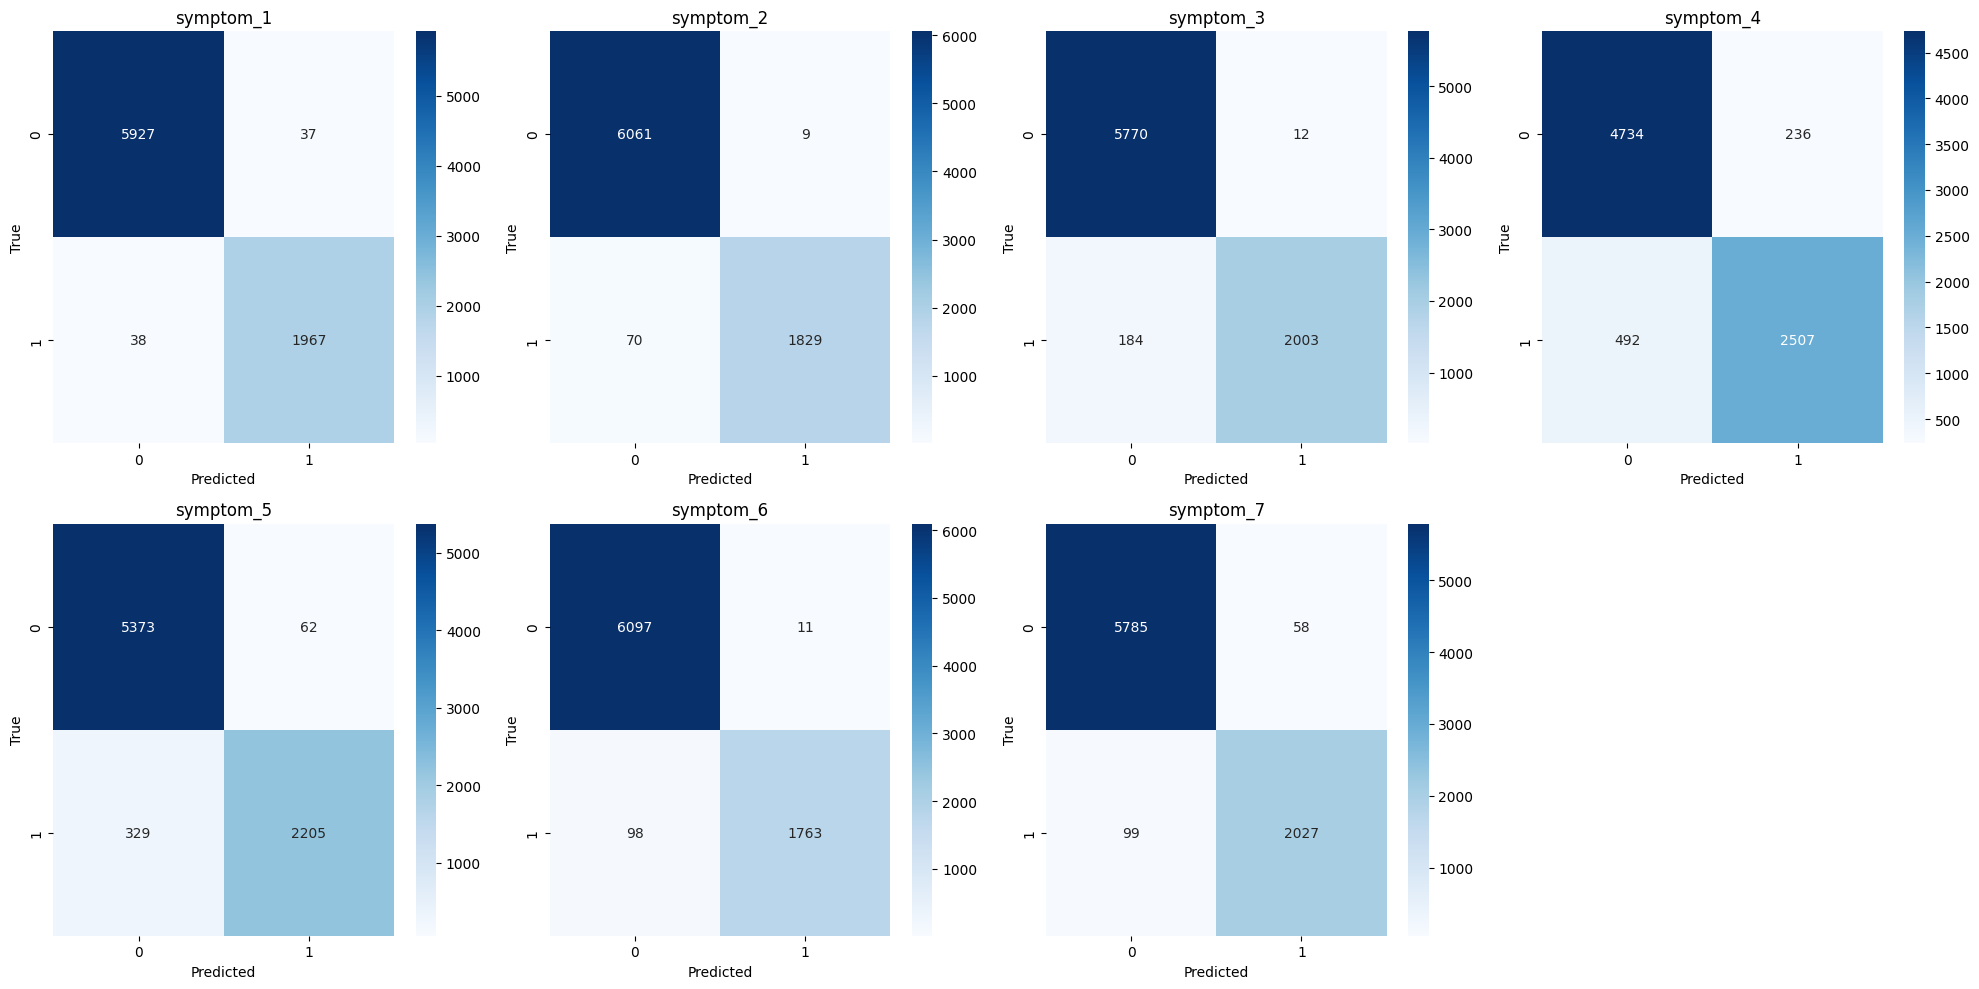

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import matplotlib.pyplot as plt


# Calculate the confusion matrix
# Since this is a multi-label classification problem, we'll use multilabel_confusion_matrix
cm = multilabel_confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
# label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']

# Create a grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.delaxes(axes[1, 3])  # remove the last subplot (as we have only 7 labels)

for i, (label_name, ax) in enumerate(zip(label_names, axes.flat)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{label_name}')

plt.tight_layout()
plt.show()

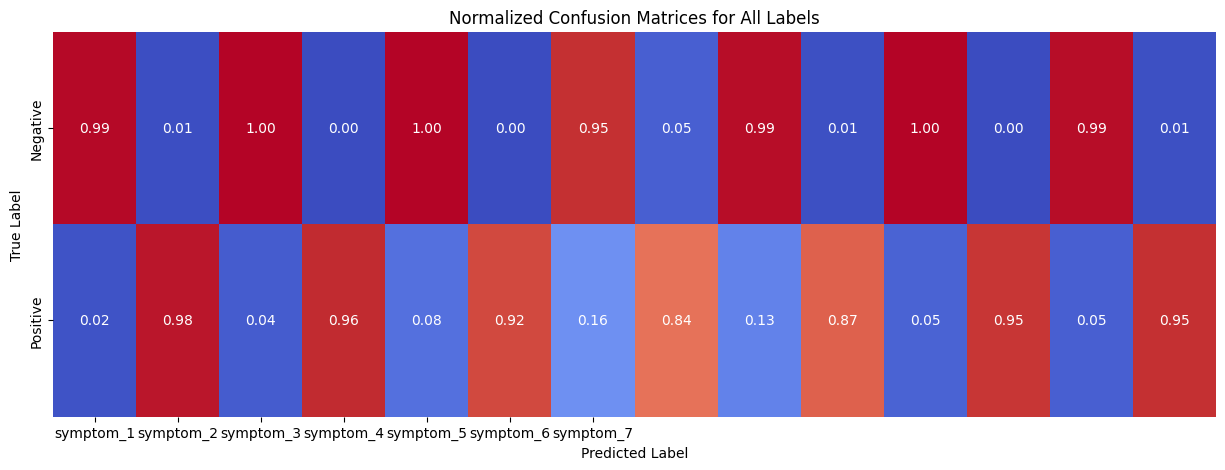

In [ ]:
# Create an empty list to store the normalized confusion matrices for each label
confusion_matrices = []

# Calculate the confusion matrices for each label and normalize them
for i in range(7):
    cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    confusion_matrices.append(cm_normalized)

# Combine the normalized confusion matrices into a single array
combined_cm = np.concatenate(confusion_matrices, axis=1)

# Plot the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(combined_cm, annot=True, cmap="coolwarm", fmt=".2f", cbar=False, xticklabels=label_names, yticklabels=["Negative", "Positive"])

plt.title("Normalized Confusion Matrices for All Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


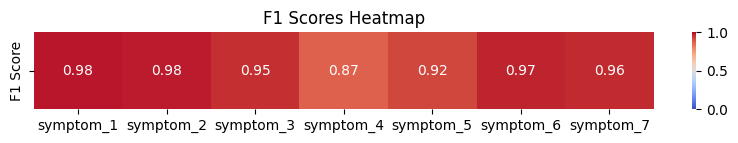

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Extract F1 scores for each label
f1_scores = {label: report[label]['f1-score'] for label in label_names}

# Create a heatmap of F1 scores
f1_scores_matrix = np.array(list(f1_scores.values())).reshape(1, -1)
plt.figure(figsize=(10, 1))
sns.heatmap(f1_scores_matrix, annot=True, fmt='.2f', xticklabels=label_names, yticklabels=['F1 Score'], cmap='coolwarm', vmin=0, vmax=1)
plt.title('F1 Scores Heatmap')
plt.show()


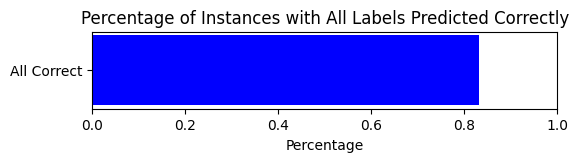

Exact Match Ratio: 0.83


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def all_correct_percentage(y_true, y_pred):
    correct = np.all(y_true == y_pred, axis=1)
    percentage = np.sum(correct) / len(correct)
    return percentage

# Calculate the percentage of instances with all labels predicted correctly
all_correct_pct = all_correct_percentage(true_labels, predicted_labels)

# Visualize the percentage
fig, ax = plt.subplots(figsize=(6, 1))
ax.barh(['All Correct'], [all_correct_pct], color='blue')
ax.set_xlim(0, 1)
ax.set_xlabel('Percentage')
ax.set_title('Percentage of Instances with All Labels Predicted Correctly')
plt.show()

def exact_match_ratio(true_labels, predicted_labels):
    assert true_labels.shape == predicted_labels.shape
    return np.all(true_labels == predicted_labels, axis=1).mean()

exact_match = exact_match_ratio(true_labels, predicted_labels)
print(f"Exact Match Ratio: {exact_match:.2f}")


symptom_1: Precision=0.98, Recall=0.98, F1 Score=0.98
symptom_2: Precision=1.00, Recall=0.96, F1 Score=0.98
symptom_3: Precision=0.99, Recall=0.92, F1 Score=0.95
symptom_4: Precision=0.91, Recall=0.84, F1 Score=0.87
symptom_5: Precision=0.97, Recall=0.87, F1 Score=0.92
symptom_6: Precision=0.99, Recall=0.95, F1 Score=0.97
symptom_7: Precision=0.97, Recall=0.95, F1 Score=0.96
Accuracy: 0.72


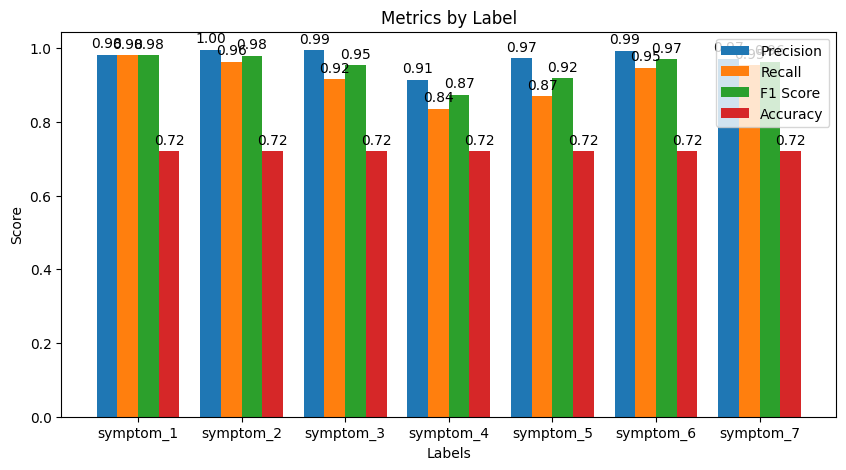

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract precision, recall, and F1 score from the classification report
precision = [report[label]['precision'] for label in label_names]
recall = [report[label]['recall'] for label in label_names]
f1_score = [report[label]['f1-score'] for label in label_names]

# Print the metric values
for label, p, r, f in zip(label_names, precision, recall, f1_score):
    print(f"{label}: Precision={p:.2f}, Recall={r:.2f}, F1 Score={f:.2f}")

print(f"Accuracy: {evaluation_results[1]:.2f}")

# Visualize the metrics together
fig, ax = plt.subplots(figsize=(10, 5))
labels = np.arange(len(label_names))
width = 0.2

rects1 = ax.bar(labels - 1.5 * width, precision, width, label='Precision')
rects2 = ax.bar(labels - 0.5 * width, recall, width, label='Recall')
rects3 = ax.bar(labels + 0.5 * width, f1_score, width, label='F1 Score')
rects4 = ax.bar(labels + 1.5 * width, [evaluation_results[1]] * len(labels), width, label='Accuracy')

ax.set_xlabel('Labels')
ax.set_xticks(labels)
ax.set_xticklabels(label_names)
ax.set_ylabel('Score')
ax.set_title('Metrics by Label')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()


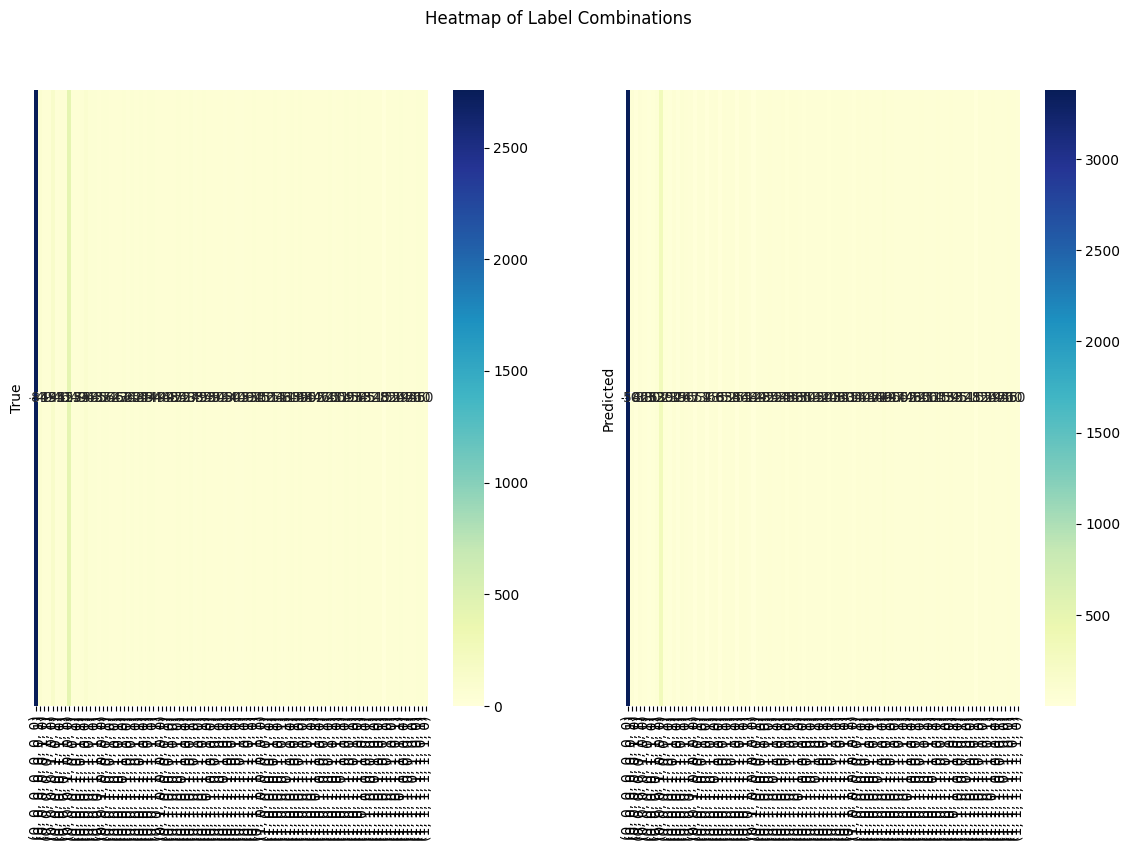

In [ ]:
import seaborn as sns
from collections import Counter

def label_combination_counts(labels):
    label_counts = Counter()
    for row in labels:
        label_counts[tuple(row)] += 1
    return label_counts

true_label_counts = label_combination_counts(true_labels)
predicted_label_counts = label_combination_counts(predicted_labels)

label_combinations = sorted(set(list(true_label_counts.keys()) + list(predicted_label_counts.keys())))
true_label_freq = [true_label_counts[combination] for combination in label_combinations]
predicted_label_freq = [predicted_label_counts[combination] for combination in label_combinations]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
fig.suptitle('Heatmap of Label Combinations')

sns.heatmap([true_label_freq], xticklabels=label_combinations, yticklabels=["True"], annot=True, fmt="d", cmap="YlGnBu", ax=ax1)
sns.heatmap([predicted_label_freq], xticklabels=label_combinations, yticklabels=["Predicted"], annot=True, fmt="d", cmap="YlGnBu", ax=ax2)

plt.show()


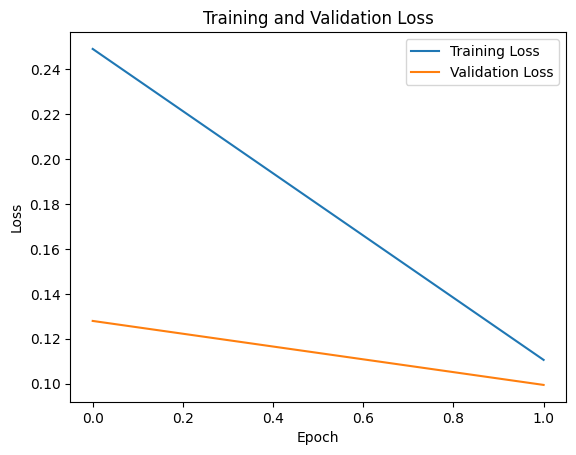

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

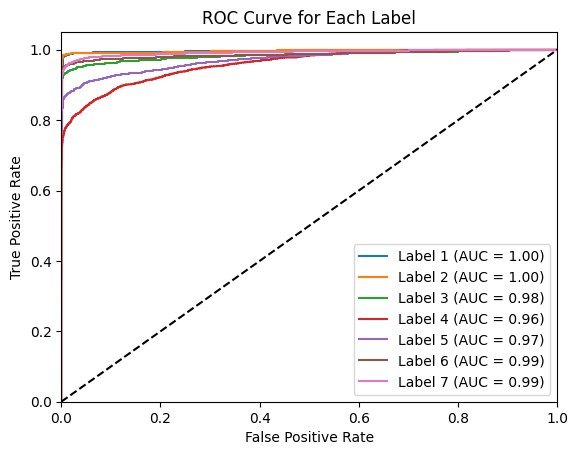

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate ROC curve and AUC for each label

n_classes = train_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Rest of the code remains the same


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Label {i + 1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Label')
plt.legend(loc="lower right")
plt.show()

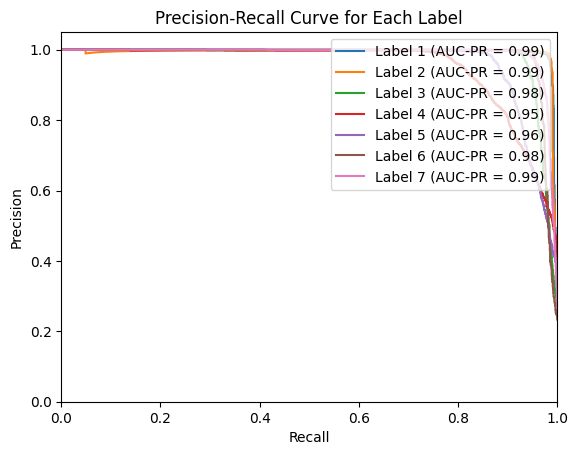

In [ ]:
# Calculate Precision-Recall curve and AUC-PR for each label
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels[:, i], logits[:, i])
    average_precision[i] = average_precision_score(true_labels[:, i], logits[:, i])

# Plot Precision-Recall curve
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Label {i + 1} (AUC-PR = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Label')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# from transformers import TFBertModel

# # Get the attention weights from BERT
# def get_attention_weights(input_ids, attention_masks):
#     bert = TFBertModel.from_pretrained('bert-base-uncased', output_attentions=True)
#     outputs = bert(input_ids, attention_mask=attention_masks)
#     attentions = outputs.attentions
#     return attentions

# # Analyze the attention weights for a specific sample
# sample_index = 0  # Change this to analyze different samples
# input_id_sample = test_input_ids[sample_index].reshape(1, -1)
# attention_mask_sample = test_attention_masks[sample_index].reshape(1, -1)

# # Convert tensors to the appropriate format
# input_id_sample = tf.convert_to_tensor(input_id_sample)
# attention_mask_sample = tf.convert_to_tensor(attention_mask_sample)

# attentions = get_attention_weights(input_id_sample, attention_mask_sample)

# # Get the words from the input_ids
# tokens = tokenizer.convert_ids_to_tokens(input_id_sample[0])

# # Print the attention weights for the sample
# for i, attention in enumerate(attentions):
#     print(f"Layer {i + 1}")
#     print(tokens)
#     print(attention[0][0].numpy())
#     print("\n")


In [ ]:
# '''qualitative example'''
# # Define indices of examples to examine
# example_indices = [0, 1, 2, 3, 4, 5, 6]

# # Convert the predicted probabilities to binary labels
# test_predictions = model.predict([test_input_ids, test_attention_masks])
# test_binary_predictions = (np.array(test_predictions.logits, dtype=float) >= 0.5).astype(int)

# # Define label names
# label_names = ['happiness', 'love', 'enthusiasm', 'fun', 'surprise', 'neutral', 'sadness']

# # Choose some examples to examine in more detail
# for i in example_indices:
#     # Get the input text and true label for the example
#     input_text = df['Content'].iloc[test_index[i]]
#     true_label = test_labels[i]

#     # Get the predicted label for the example
#     predicted_label = test_binary_predictions[i]

#     # Map the predicted label indices to their names
#     predicted_label_names = [label_names[j] for j, label in enumerate(predicted_label) if label == 1]

#     # Print the input text, true label, and predicted label
#     print("Input text:", input_text)
#     print("True label:", true_label)
#     print("Predicted label:", predicted_label)

   


In [ ]:
# Error analysis
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels



250/250 [==============================] - 223s 893ms/step


In [ ]:
errors = []
for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)):
    if not np.array_equal(pred, true):
        errors.append(i)

print(f"Total errors: {len(errors)}")


# Inspect a specific error
for i in range(1000):
  error_index = errors[i]  # Change this to analyze different errors
  error_df_index = test_index[error_index]  # Get the index in the original dataframe
  print(f"Error {error_index}")
  print("Content: ", df.iloc[error_df_index]['Content'])  # Print the content of the misclassified sample
  print("True labels: ", true_labels[error_index])
  print("Predicted labels: ", predicted_labels[error_index])
  error_content = df.iloc[error_df_index]['Content']
  # print(f"Content: {error_content}")


Total errors: 1340
Error 7
Content:  Mel could right, I never know never say anything
True labels:  [0 0 0 1 0 1 0]
Predicted labels:  [0 0 0 0 0 0 0]
Error 8
Content:  I Have dealing low point since like feb year I like hah! It cannot get worse last year! I fine!! But day I get lower lower think lowest ever
True labels:  [0 0 1 0 0 0 0]
Predicted labels:  [0 0 0 1 0 0 0]
Error 9
Content:  Not saying try cry feel like could , good card play
True labels:  [0 0 0 0 1 0 1]
Predicted labels:  [0 0 0 1 0 0 0]
Error 17
Content:  I anxiety able deal it, becoming breathing problem. I find quite dangerous worrying
True labels:  [0 0 0 0 0 0 0]
Predicted labels:  [0 0 0 1 0 0 0]
Error 19
Content:  Mikaela try watch gameplaysyoutube vids, get mind elsewhere. I Am sorry hard time breathing, etc.
True labels:  [0 0 0 0 0 0 0]
Predicted labels:  [1 0 0 0 0 0 0]
Error 20
Content:  Actually every single relationship I LDR, ik sort thing feel
True labels:  [0 0 0 0 1 0 0]
Predicted labels:  [0 0 0 0 0 

In [ ]:
error_content = df.iloc[error_df_index]['Content']
print(f"Content: {error_content}")

In [ ]:
print(f"Total errors: {len(errors)}")

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


RoBERTa Attention Visualization for Layer 1, Head 4:
Attention values (Layer 1, Head 4):
[[0.0777 0.0605 0.0272 0.0798 0.0172 0.0412 0.1084 0.0437 0.1241 0.0292
  0.1355 0.1446 0.1108]
 [0.0668 0.2191 0.0329 0.0288 0.0139 0.0369 0.0355 0.0448 0.0699 0.1193
  0.0445 0.1011 0.1864]
 [0.0965 0.083  0.1268 0.0401 0.0542 0.058  0.0485 0.0713 0.0429 0.0893
  0.0669 0.1194 0.1032]
 [0.1338 0.1283 0.1215 0.0614 0.0594 0.052  0.0597 0.0647 0.055  0.0672
  0.0239 0.0716 0.1015]
 [0.0676 0.0692 0.1813 0.0225 0.077  0.047  0.0328 0.1068 0.0774 0.1127
  0.027  0.1103 0.0685]
 [0.1041 0.0464 0.0547 0.041  0.0248 0.1992 0.0505 0.0918 0.1071 0.0316
  0.0592 0.0848 0.1046]
 [0.1011 0.1232 0.1341 0.0733 0.0558 0.0522 0.067  0.0628 0.0564 0.0621
  0.0293 0.0789 0.1037]
 [0.0616 0.1192 0.0752 0.0238 0.1397 0.0903 0.0199 0.1943 0.0268 0.1453
  0.0195 0.0481 0.0363]
 [0.0632 0.1105 0.1147 0.0671 0.068  0.0793 0.0551 0.0615 0.1244 0.0605
  0.0625 0.0585 0.0747]
 [0.0616 0.112  0.0517 0.0879 0.047  0.06   0.0

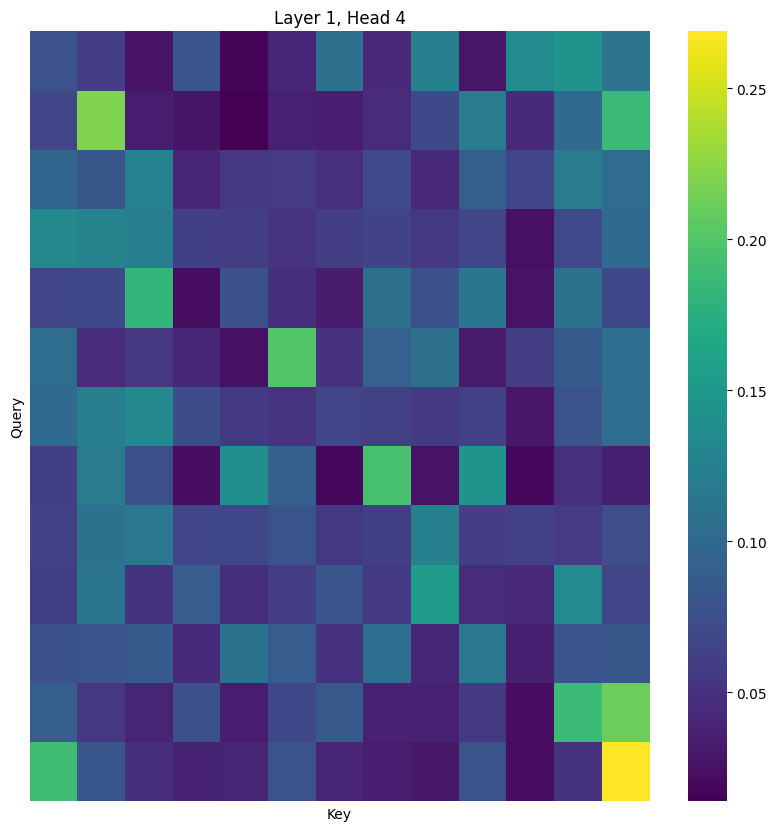

RoBERTa Attention Visualization for Layer 1, Head 3:
Attention values (Layer 1, Head 3):
[[0.0656 0.0716 0.0926 0.098  0.0549 0.037  0.0479 0.04   0.0504 0.0493
  0.0641 0.1077 0.2211]
 [0.0554 0.0266 0.0838 0.0516 0.0587 0.0474 0.0694 0.0713 0.0715 0.0657
  0.0679 0.0886 0.2421]
 [0.1643 0.0728 0.0215 0.0972 0.0336 0.0794 0.0993 0.0433 0.0949 0.0586
  0.047  0.0452 0.1429]
 [0.1024 0.0748 0.0637 0.083  0.1054 0.0895 0.0979 0.0752 0.0692 0.0727
  0.0515 0.0479 0.0666]
 [0.148  0.0876 0.0585 0.0902 0.0385 0.108  0.0666 0.0591 0.0664 0.0676
  0.0683 0.0409 0.1002]
 [0.1109 0.0823 0.1171 0.062  0.1823 0.0042 0.0471 0.0499 0.0568 0.0597
  0.0629 0.0574 0.1075]
 [0.1378 0.0808 0.0557 0.0786 0.0892 0.0767 0.0967 0.0699 0.073  0.0767
  0.0426 0.0528 0.0694]
 [0.1635 0.0985 0.0823 0.0919 0.1241 0.0381 0.0627 0.0319 0.0305 0.097
  0.0422 0.0498 0.0877]
 [0.1689 0.0575 0.0674 0.0611 0.0896 0.0482 0.0676 0.057  0.0664 0.0946
  0.0522 0.0854 0.0841]
 [0.1495 0.067  0.1094 0.1079 0.0476 0.0795 0.05

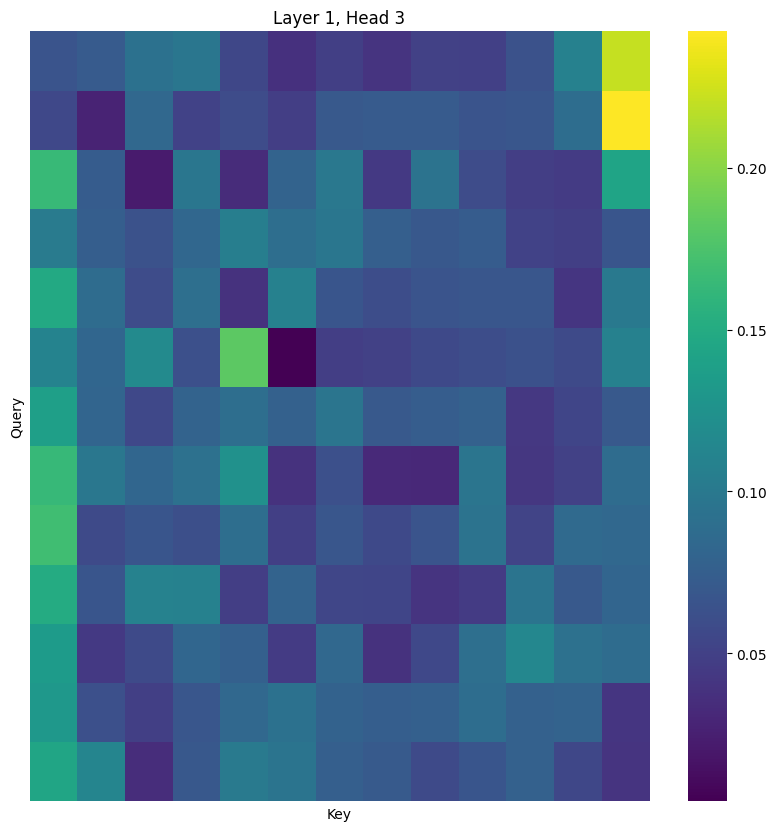

RoBERTa Attention Visualization for Layer 1, Head 2:
Attention values (Layer 1, Head 2):
[[0.5206 0.0223 0.0251 0.0181 0.0262 0.0359 0.0192 0.0247 0.0422 0.0188
  0.0135 0.2079 0.0255]
 [0.0163 0.1289 0.1368 0.0368 0.1113 0.0896 0.0366 0.1244 0.0442 0.1712
  0.038  0.0298 0.036 ]
 [0.0195 0.1227 0.1064 0.0163 0.1665 0.1255 0.0159 0.163  0.0347 0.1376
  0.0277 0.0179 0.0463]
 [0.0406 0.0681 0.0187 0.1919 0.043  0.0196 0.1731 0.047  0.0784 0.0286
  0.0551 0.1262 0.1095]
 [0.013  0.1335 0.1712 0.0179 0.1248 0.0832 0.0182 0.2252 0.0266 0.1173
  0.0276 0.0172 0.0244]
 [0.0082 0.1049 0.0916 0.0211 0.1419 0.1967 0.0205 0.1538 0.0401 0.1265
  0.0619 0.011  0.0217]
 [0.0403 0.065  0.0172 0.1925 0.0399 0.0204 0.1635 0.0455 0.0666 0.0276
  0.0582 0.1447 0.1186]
 [0.0076 0.0999 0.1237 0.0193 0.2368 0.1248 0.0179 0.1438 0.0323 0.0849
  0.0566 0.0186 0.0338]
 [0.0376 0.1132 0.0492 0.0474 0.1134 0.1836 0.0422 0.1063 0.0403 0.0641
  0.0667 0.061  0.0749]
 [0.0136 0.1366 0.1437 0.0113 0.1512 0.155  0.0

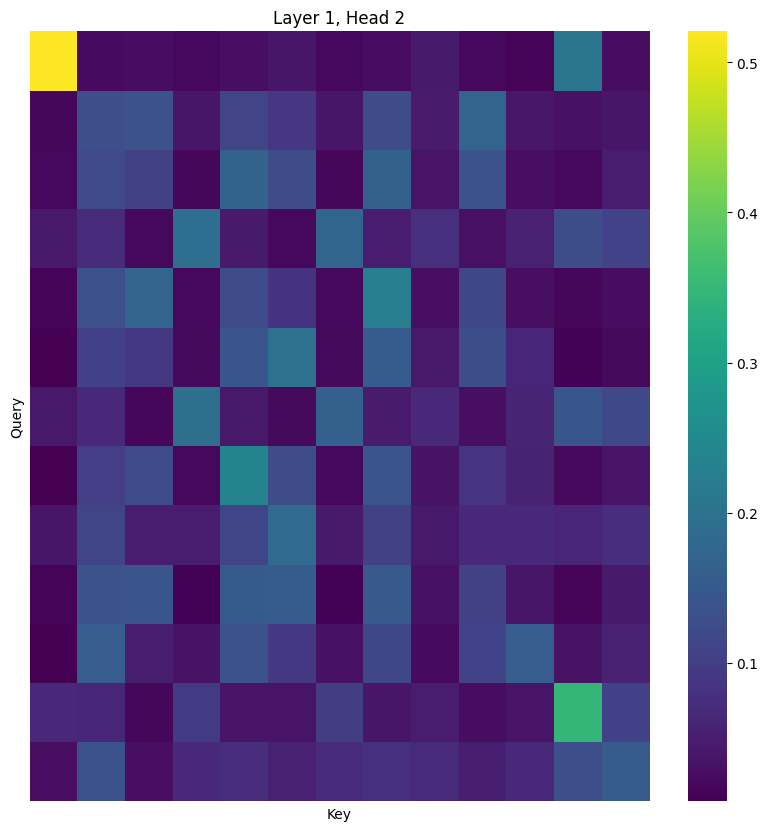

RoBERTa Attention Visualization for Layer 12, Head 11:
Attention values (Layer 12, Head 11):
[[3.403e-01 2.050e-02 3.260e-02 4.780e-02 2.040e-02 6.500e-03 4.230e-02
  2.070e-02 1.730e-02 1.430e-02 1.560e-02 3.391e-01 8.270e-02]
 [4.528e-01 1.780e-02 9.000e-04 5.050e-02 1.130e-02 3.000e-04 1.720e-02
  1.900e-03 2.500e-03 1.200e-03 3.100e-03 4.185e-01 2.210e-02]
 [3.279e-01 2.320e-02 9.130e-02 7.070e-02 1.200e-02 3.500e-03 4.180e-02
  6.300e-03 9.900e-03 2.000e-03 4.440e-02 3.071e-01 5.970e-02]
 [3.888e-01 2.970e-02 7.000e-03 7.620e-02 2.850e-02 3.600e-03 3.590e-02
  9.300e-03 4.900e-03 1.800e-03 9.600e-03 3.761e-01 2.850e-02]
 [4.790e-01 2.500e-03 3.000e-04 3.110e-02 1.590e-02 4.000e-04 1.310e-02
  1.600e-03 1.000e-03 2.000e-04 9.000e-04 4.372e-01 1.680e-02]
 [5.069e-01 1.300e-03 5.000e-04 5.800e-03 3.600e-03 2.800e-03 4.300e-03
  2.300e-03 1.500e-03 2.000e-04 1.200e-03 4.642e-01 5.600e-03]
 [3.793e-01 1.910e-02 6.000e-03 6.730e-02 3.000e-02 7.400e-03 6.130e-02
  1.540e-02 1.060e-02 2.4

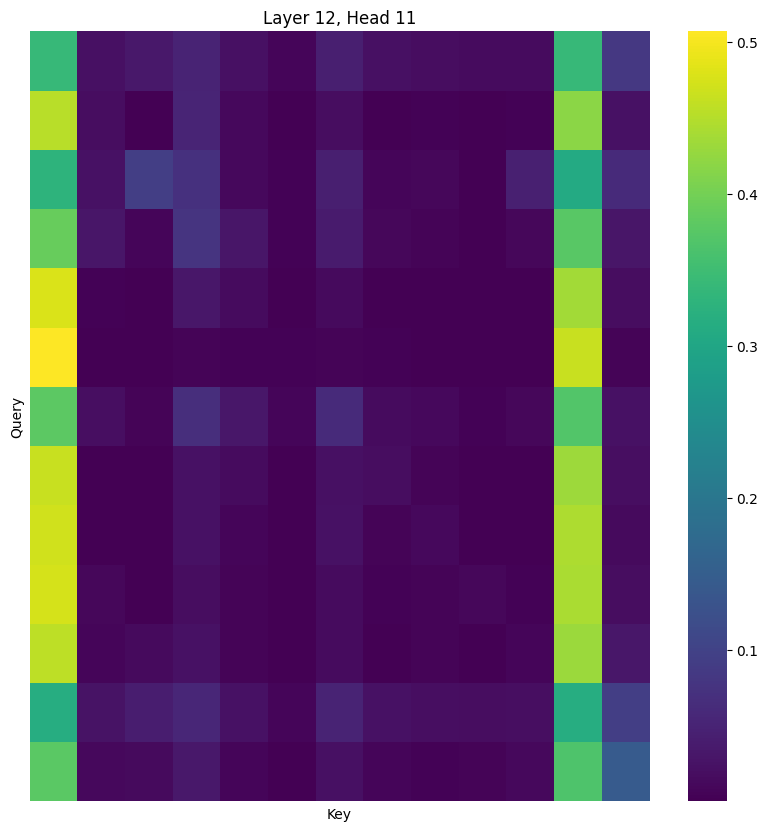

RoBERTa Attention Visualization for Layer 12, Head 12:
Attention values (Layer 12, Head 12):
[[0.2125 0.0506 0.0624 0.0789 0.0726 0.0259 0.0482 0.0735 0.0425 0.0423
  0.0348 0.2206 0.0352]
 [0.3927 0.0447 0.0562 0.0446 0.0085 0.0039 0.0134 0.0016 0.0013 0.0023
  0.018  0.3978 0.0149]
 [0.2816 0.0884 0.0309 0.0604 0.0863 0.0254 0.0275 0.0142 0.0191 0.0414
  0.0383 0.2664 0.0201]
 [0.3661 0.0261 0.0337 0.043  0.043  0.0334 0.0297 0.0139 0.0057 0.0182
  0.0223 0.3471 0.0178]
 [0.4181 0.0061 0.0118 0.0247 0.0127 0.0276 0.028  0.0112 0.0095 0.0078
  0.0138 0.4114 0.0174]
 [0.4764 0.0025 0.0035 0.0044 0.0058 0.0136 0.0089 0.0059 0.0092 0.0092
  0.0057 0.4518 0.0032]
 [0.3798 0.0105 0.0173 0.0271 0.0261 0.029  0.0415 0.0311 0.0154 0.0253
  0.0131 0.3737 0.0101]
 [0.3771 0.0043 0.0046 0.0145 0.0095 0.0156 0.0478 0.0242 0.0661 0.0275
  0.0083 0.3909 0.0095]
 [0.4752 0.0007 0.0023 0.0029 0.0009 0.0023 0.0073 0.003  0.0114 0.0206
  0.0076 0.4612 0.0047]
 [0.4773 0.0016 0.0079 0.0022 0.0013 0.0022

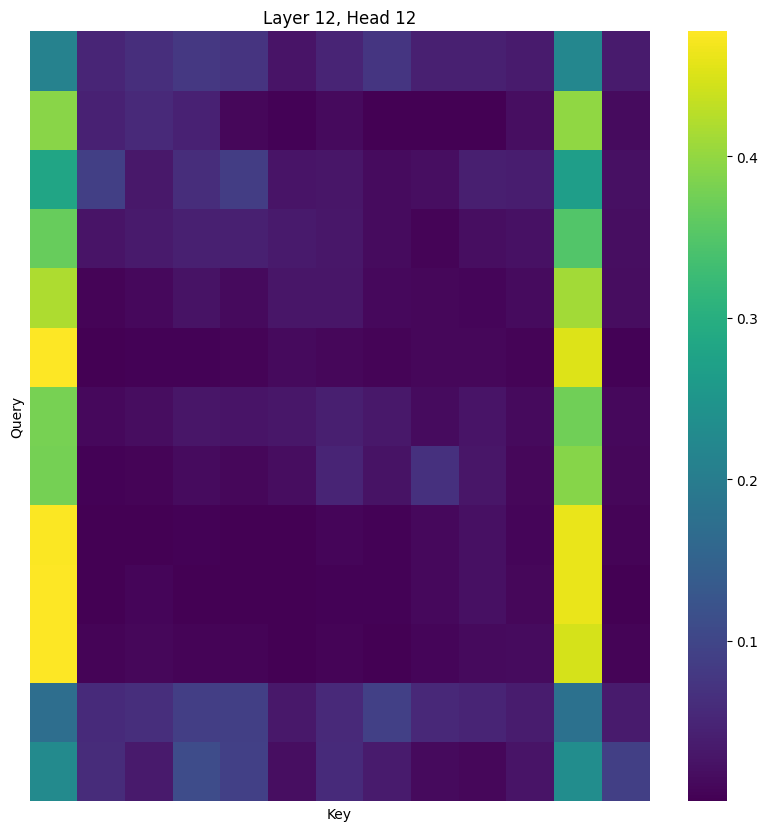

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, TFRobertaModel

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# sample_sentence = "Can't sleep, always tired, hard to focus."
sample_sentence = "Lost appetite, feel guilty, thinking of ending it."

roberta_tokens = tokenizer.encode_plus(sample_sentence, add_special_tokens=True, return_tensors="tf")
roberta_outputs = roberta_model(roberta_tokens['input_ids'], attention_mask=roberta_tokens['attention_mask'], output_attentions=True)
roberta_attention = roberta_outputs.attentions

def plot_attention(tokens, attention, layer, head):
    plt.figure(figsize=(10, 10))
    tokens = tokenizer.convert_ids_to_tokens(tokens.numpy()[0])
    attention_values = attention[layer][0, head].numpy()
    print(f"Attention values (Layer {layer + 1}, Head {head + 1}):")
    print(np.round(attention_values, decimals=4))
    ax = sns.heatmap(attention_values, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)
    ax.xaxis.tick_top()
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.title(f"Layer {layer + 1}, Head {head + 1}")
    plt.show()

selected_heads = [(0, 3), (0, 2), (0, 1), (11, 10), (11, 11)]

for layer, head in selected_heads:
  print(f"RoBERTa Attention Visualization for Layer {layer + 1}, Head {head + 1}:")
  plot_attention(roberta_tokens['input_ids'], roberta_attention, layer, head)


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


RoBERTa Attention Visualization for Layer 1, Head 4:
Attention values (Layer 1, Head 4):
[[0.075  0.0439 0.0682 0.0283 0.0722 0.0244 0.0188 0.135  0.0702 0.1718
  0.0457 0.1395 0.107 ]
 [0.0513 0.0655 0.0764 0.038  0.082  0.0305 0.0508 0.065  0.0575 0.0494
  0.0654 0.1292 0.2392]
 [0.0828 0.1738 0.0606 0.0309 0.0384 0.0748 0.0777 0.0353 0.0665 0.0615
  0.1438 0.0844 0.0694]
 [0.044  0.0612 0.0466 0.2485 0.0253 0.0263 0.0761 0.0341 0.0962 0.029
  0.1888 0.0887 0.0352]
 [0.1337 0.0707 0.0521 0.0487 0.073  0.0617 0.0756 0.0727 0.0566 0.065
  0.1012 0.0822 0.1068]
 [0.0596 0.1052 0.0739 0.0297 0.0393 0.0873 0.0647 0.0356 0.0886 0.0419
  0.2235 0.0517 0.099 ]
 [0.0308 0.0578 0.0467 0.1379 0.0319 0.0724 0.1639 0.0246 0.1    0.0262
  0.1762 0.0774 0.0541]
 [0.1207 0.0687 0.0488 0.0567 0.0873 0.0691 0.0853 0.0712 0.0573 0.0572
  0.0879 0.0825 0.1075]
 [0.048  0.1141 0.1405 0.0714 0.0889 0.0663 0.1324 0.0601 0.0546 0.05
  0.07   0.0397 0.064 ]
 [0.0996 0.1128 0.0704 0.0556 0.0782 0.0678 0.0771 

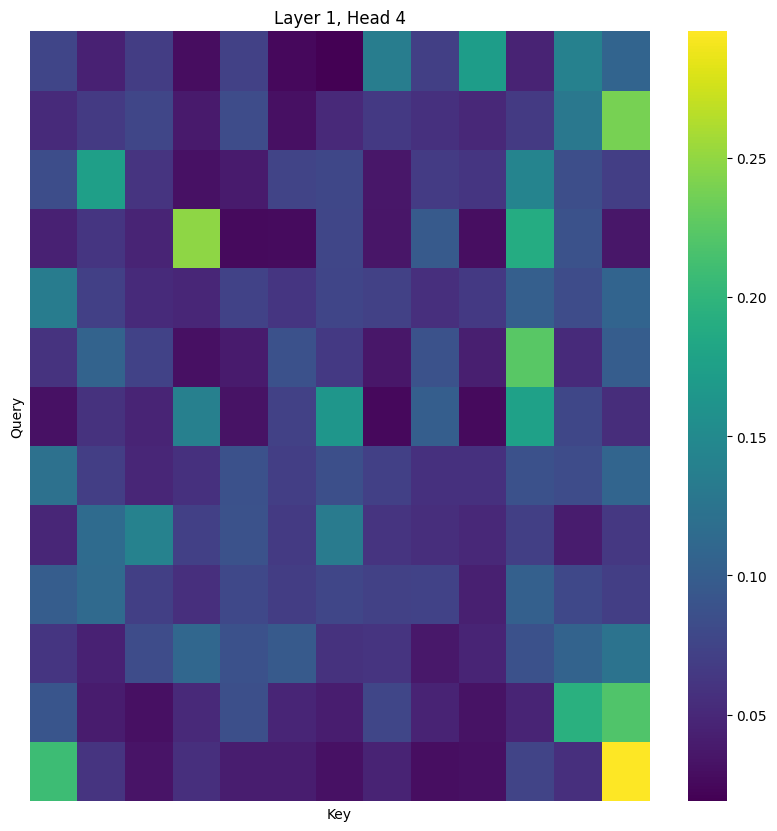

RoBERTa Attention Visualization for Layer 1, Head 3:
Attention values (Layer 1, Head 3):
[[0.0589 0.1032 0.0804 0.0879 0.0729 0.0416 0.0409 0.0366 0.0312 0.0906
  0.0608 0.0967 0.1986]
 [0.1034 0.0201 0.0206 0.0741 0.0545 0.0972 0.0444 0.0702 0.1073 0.0505
  0.1231 0.0742 0.1603]
 [0.0571 0.0516 0.018  0.0566 0.0834 0.0393 0.0316 0.1101 0.0818 0.1217
  0.0589 0.0865 0.2034]
 [0.4028 0.0361 0.0277 0.0332 0.0581 0.0635 0.0645 0.0512 0.0547 0.0427
  0.0496 0.0532 0.0628]
 [0.1248 0.0548 0.0925 0.0595 0.081  0.1044 0.0802 0.0962 0.0945 0.0532
  0.047  0.0422 0.0696]
 [0.0901 0.0471 0.0383 0.0373 0.0636 0.0629 0.0545 0.1069 0.1663 0.1269
  0.054  0.0544 0.0978]
 [0.0759 0.088  0.0498 0.0788 0.0594 0.0347 0.0113 0.0642 0.0337 0.1202
  0.0823 0.1803 0.1214]
 [0.1223 0.0563 0.1016 0.0618 0.0818 0.0998 0.0796 0.0875 0.0874 0.0544
  0.0509 0.0552 0.0614]
 [0.2091 0.0309 0.0543 0.1253 0.0844 0.1124 0.0417 0.0339 0.0203 0.0234
  0.1013 0.0945 0.0685]
 [0.1779 0.0522 0.0654 0.0473 0.0786 0.091  0.0

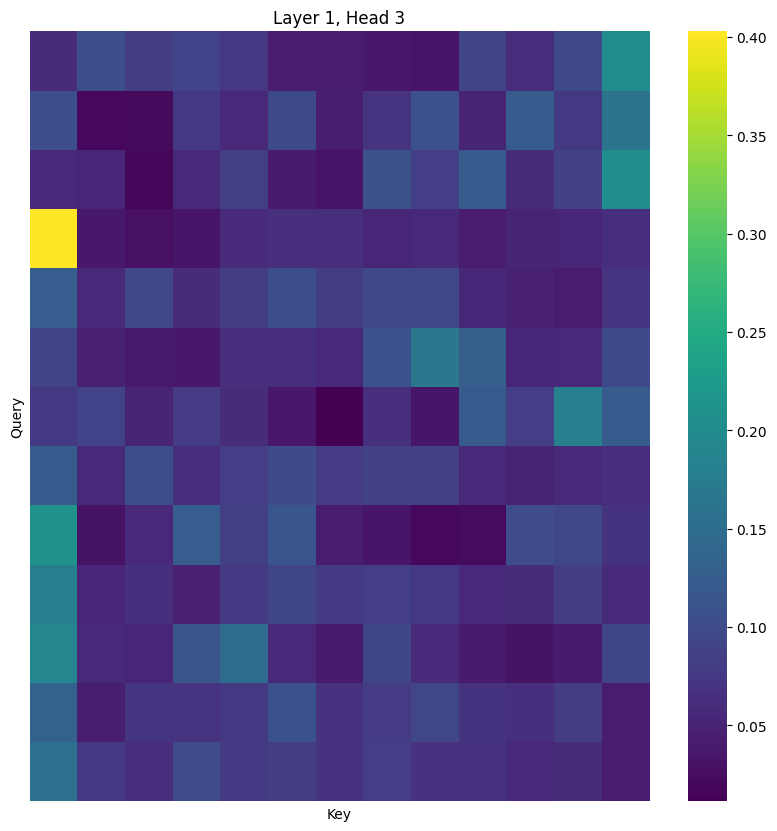

RoBERTa Attention Visualization for Layer 1, Head 2:
Attention values (Layer 1, Head 2):
[[0.5283 0.0125 0.0166 0.0316 0.0203 0.0076 0.0376 0.0181 0.0292 0.0449
  0.0165 0.2109 0.0259]
 [0.0653 0.0448 0.1279 0.1231 0.04   0.092  0.0879 0.0376 0.0415 0.0563
  0.1577 0.0651 0.061 ]
 [0.0145 0.1146 0.1138 0.0415 0.0465 0.1857 0.1037 0.0457 0.0698 0.0405
  0.1311 0.0313 0.0614]
 [0.0045 0.0568 0.0454 0.091  0.0216 0.0763 0.3063 0.0221 0.1108 0.0071
  0.1973 0.0114 0.0496]
 [0.0382 0.0784 0.1304 0.0364 0.1524 0.0437 0.0311 0.1445 0.0229 0.0563
  0.0484 0.1217 0.0956]
 [0.0113 0.1193 0.1219 0.1068 0.0207 0.1    0.1604 0.021  0.0927 0.0344
  0.1434 0.0176 0.0504]
 [0.003  0.0165 0.023  0.6484 0.0097 0.0449 0.0707 0.0099 0.037  0.0109
  0.1105 0.0068 0.0087]
 [0.0363 0.0709 0.1269 0.0365 0.1423 0.043  0.033  0.1316 0.024  0.0574
  0.0556 0.1305 0.1121]
 [0.0223 0.0357 0.0449 0.2314 0.0102 0.0802 0.2574 0.01   0.0601 0.0099
  0.1899 0.0203 0.0276]
 [0.0525 0.0525 0.0815 0.0587 0.0474 0.099  0.1

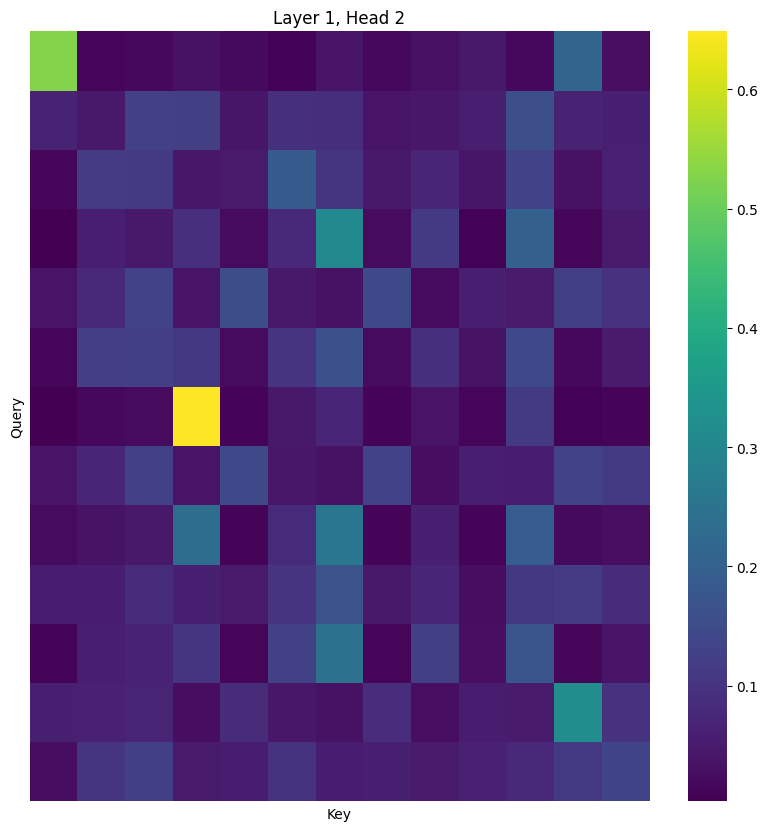

RoBERTa Attention Visualization for Layer 12, Head 11:
Attention values (Layer 12, Head 11):
[[3.336e-01 2.910e-02 2.270e-02 3.040e-02 3.050e-02 1.640e-02 2.760e-02
  3.250e-02 1.420e-02 2.070e-02 2.610e-02 3.312e-01 8.480e-02]
 [4.674e-01 2.810e-02 1.080e-02 1.000e-03 1.990e-02 2.300e-03 5.000e-04
  6.500e-03 7.000e-04 2.400e-03 3.000e-04 4.345e-01 2.580e-02]
 [4.886e-01 7.300e-03 9.600e-03 1.100e-03 7.100e-03 1.000e-03 3.000e-04
  2.600e-03 3.000e-04 1.400e-03 2.000e-04 4.704e-01 1.010e-02]
 [4.515e-01 1.310e-02 2.250e-02 1.870e-02 2.190e-02 2.900e-03 2.200e-03
  1.320e-02 7.000e-04 4.100e-03 3.000e-03 4.259e-01 2.020e-02]
 [4.604e-01 1.610e-02 1.040e-02 3.900e-03 1.790e-02 3.400e-03 4.700e-03
  1.060e-02 1.300e-03 2.900e-03 8.000e-04 4.417e-01 2.600e-02]
 [4.287e-01 1.230e-02 1.020e-02 2.800e-03 2.870e-02 3.020e-02 2.600e-03
  2.030e-02 1.500e-03 3.800e-03 6.000e-04 4.096e-01 4.880e-02]
 [5.034e-01 2.700e-03 3.500e-03 2.500e-03 8.600e-03 2.100e-03 8.300e-03
  3.500e-03 8.000e-04 1.3

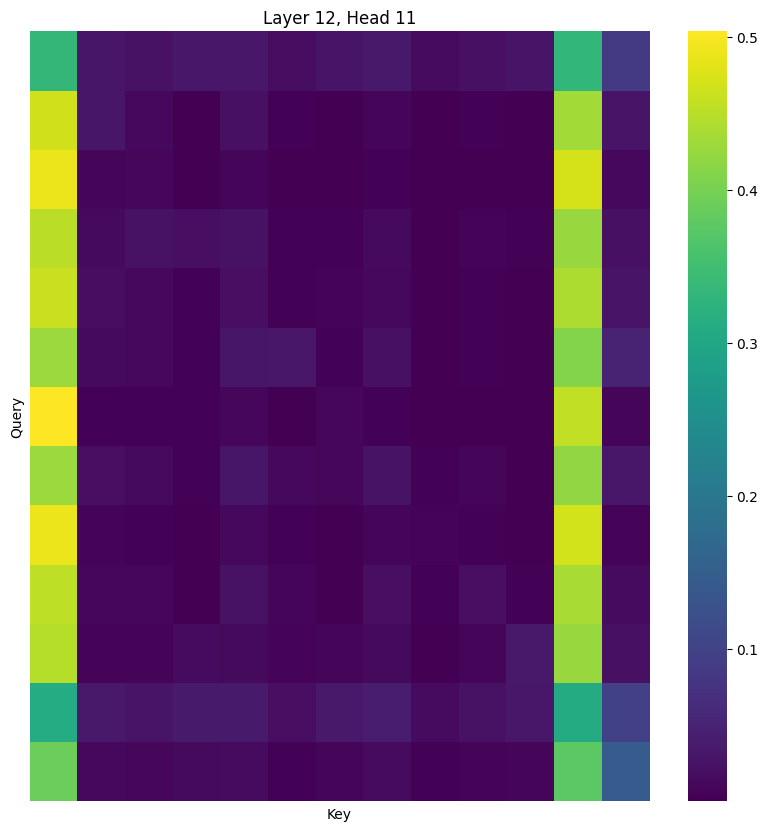

RoBERTa Attention Visualization for Layer 12, Head 12:
Attention values (Layer 12, Head 12):
[[2.449e-01 6.020e-02 6.570e-02 6.960e-02 3.880e-02 6.450e-02 5.140e-02
  2.830e-02 2.470e-02 2.410e-02 3.900e-02 2.546e-01 3.410e-02]
 [3.956e-01 2.850e-02 4.200e-02 5.330e-02 3.080e-02 3.000e-03 6.800e-03
  1.000e-02 1.200e-03 1.900e-03 3.900e-03 4.043e-01 1.860e-02]
 [4.627e-01 1.000e-02 1.620e-02 3.350e-02 7.800e-03 4.000e-04 1.700e-03
  1.800e-03 1.000e-04 3.000e-04 1.200e-03 4.573e-01 7.100e-03]
 [4.181e-01 3.560e-02 2.410e-02 3.300e-02 2.300e-02 3.900e-03 5.700e-03
  9.000e-03 2.600e-03 2.400e-03 3.400e-03 4.266e-01 1.270e-02]
 [4.468e-01 1.330e-02 1.950e-02 1.370e-02 1.190e-02 8.700e-03 1.250e-02
  8.600e-03 4.700e-03 2.400e-03 3.500e-03 4.429e-01 1.160e-02]
 [4.295e-01 7.200e-03 3.700e-03 1.390e-02 1.460e-02 7.900e-03 4.840e-02
  1.860e-02 5.400e-03 6.200e-03 6.700e-03 4.210e-01 1.690e-02]
 [4.773e-01 2.400e-03 1.100e-03 4.900e-03 5.600e-03 1.800e-03 6.700e-03
  6.100e-03 1.300e-03 9.0

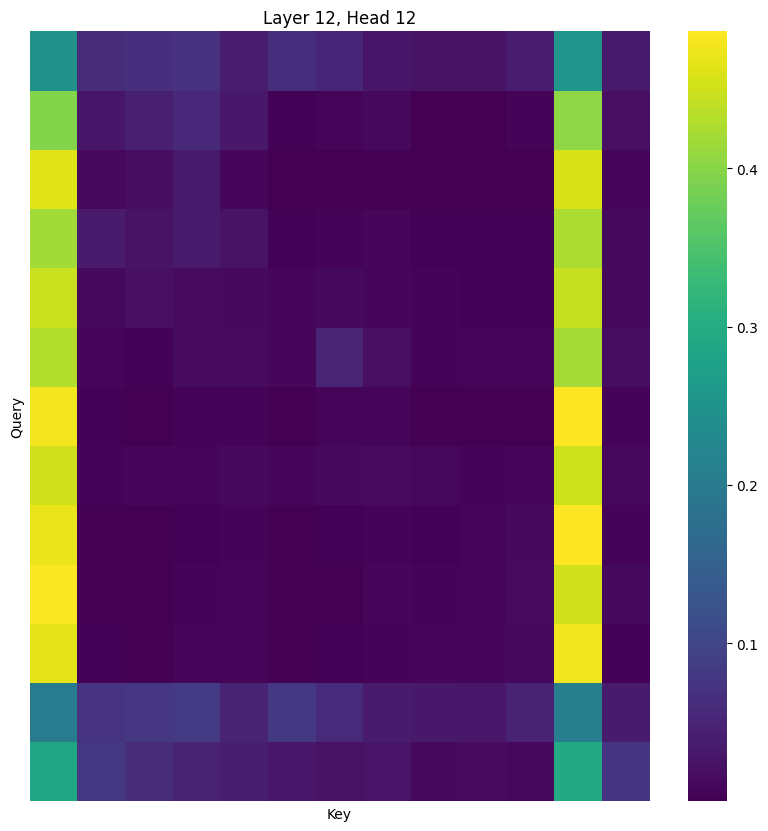

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, TFRobertaModel

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

sample_sentence = "Can't sleep, always tired, hard to focus."
# sample_sentence = "Lost appetite, feel guilty, thinking of ending it."

roberta_tokens = tokenizer.encode_plus(sample_sentence, add_special_tokens=True, return_tensors="tf")
roberta_outputs = roberta_model(roberta_tokens['input_ids'], attention_mask=roberta_tokens['attention_mask'], output_attentions=True)
roberta_attention = roberta_outputs.attentions

def plot_attention(tokens, attention, layer, head):
    plt.figure(figsize=(10, 10))
    tokens = tokenizer.convert_ids_to_tokens(tokens.numpy()[0])
    attention_values = attention[layer][0, head].numpy()
    print(f"Attention values (Layer {layer + 1}, Head {head + 1}):")
    print(np.round(attention_values, decimals=4))
    ax = sns.heatmap(attention_values, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)
    ax.xaxis.tick_top()
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.title(f"Layer {layer + 1}, Head {head + 1}")
    plt.show()

selected_heads = [(0, 3), (0, 2), (0, 1), (11, 10), (11, 11)]

for layer, head in selected_heads:
  print(f"RoBERTa Attention Visualization for Layer {layer + 1}, Head {head + 1}:")
  plot_attention(roberta_tokens['input_ids'], roberta_attention, layer, head)
